In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,valid_data,valid_label = pickle.load(f)
    return train_data,train_label,valid_data,valid_label

# data_path = 'adress_512.pkl'
data_path = 'adress_Att_Net.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,valid_data,valid_label = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(1392).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(74).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(out, labels.to(torch.int64).cuda())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [39]:
import numpy as np
import torch
from torch import nn
from torch.nn import init

class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.shape[0],-1)

class ChannelAttention(nn.Module):
    def __init__(self,channel,reduction=16,num_layers=3):
        super().__init__()
        self.avgpool=nn.AdaptiveAvgPool2d(1)
        gate_channels=[channel]
        gate_channels+=[channel//reduction]*num_layers
        gate_channels+=[channel]


        self.ca=nn.Sequential()
        self.ca.add_module('flatten',Flatten())
        for i in range(len(gate_channels)-2):
            self.ca.add_module('fc%d'%i,nn.Linear(gate_channels[i],gate_channels[i+1]))
            self.ca.add_module('bn%d'%i,nn.BatchNorm1d(gate_channels[i+1]))
            self.ca.add_module('relu%d'%i,nn.ReLU())
        self.ca.add_module('last_fc',nn.Linear(gate_channels[-2],gate_channels[-1]))
        

    def forward(self, x) :
        res=self.avgpool(x)
        res=self.ca(res)
        res=res.unsqueeze(-1).unsqueeze(-1).expand_as(x)
        return res

class SpatialAttention(nn.Module):
    def __init__(self,channel,reduction=16,num_layers=3,dia_val=2):
        super().__init__()
        self.sa=nn.Sequential()
        self.sa.add_module('conv_reduce1',nn.Conv2d(kernel_size=1,in_channels=channel,out_channels=channel//reduction))
        self.sa.add_module('bn_reduce1',nn.BatchNorm2d(channel//reduction))
        self.sa.add_module('relu_reduce1',nn.ReLU())
        for i in range(num_layers):
            self.sa.add_module('conv_%d'%i,nn.Conv2d(kernel_size=3,in_channels=channel//reduction,out_channels=channel//reduction,padding=1,dilation=dia_val))
            self.sa.add_module('bn_%d'%i,nn.BatchNorm2d(channel//reduction))
            self.sa.add_module('relu_%d'%i,nn.ReLU())
        self.sa.add_module('last_conv',nn.Conv2d(channel//reduction,1,kernel_size=1))

    def forward(self, x) :
        res=self.sa(x)
        res=res.expand_as(x)
        return res




class BAMBlock(nn.Module):

    def __init__(self, channel=512,reduction=16,dia_val=2):
        super().__init__()
        self.ca=ChannelAttention(channel=channel,reduction=reduction)
        self.sa=SpatialAttention(channel=channel,reduction=reduction,dia_val=dia_val)
        self.sigmoid=nn.Sigmoid()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        sa_out=self.sa(x)
        ca_out=self.ca(x)
        weight=self.sigmoid(sa_out+ca_out)
        out=(1+weight)*x
        return out


# if __name__ == '__main__':
#     input=torch.randn(50,512,7,7)
#     bam = BAMBlock(channel=512,reduction=16,dia_val=2)
#     output=bam(input)
#     print(output.shape)
    
    
class Att_Net(ImageClassificationBase):   
    def __init__(self):
        super(Att_Net, self).__init__()
        #The LW_CNN module utilizes three convolutions (C), two max-pooling
        # (MP), one average-pooling (AP), and one batch normalization
        # (BN) layer.
        self.LW_CNN = Sequential(
            # Defining a 2D convolution layer
#             Conv2d(300, 256, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(256),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(128),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=1, stride=1),
            
              #C1, we used 120 number of kernels with size (11
              # × 11) using (4 × 4) stride setting without padding to extract
              # initially hidden patterns from input data. 
              Conv2d(3, 120, kernel_size=(5,5), stride=(3,3), padding=0),
              MaxPool2d(kernel_size=(2,2), stride=None),
              Conv2d(120, 256, kernel_size=(3,3), stride=(1,1), padding='same'),
#               MaxPool2d(kernel_size=(2,2)),
#               Conv2d(256, 384, kernel_size=(2,2), padding='same'),
#               MaxPool2d(kernel_size=1, stride=0),
#               Conv2d(128, 1, kernel_size=(3,3), stride=(1,1), padding='same'),
              torch.nn.AvgPool2d(kernel_size=(2,2), stride=1),
              BatchNorm2d(256),
              ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(256 * 84 * 20, 64),
#             Linear(256, 64),
            Linear(64, 2),
        )

        self.attention = BAMBlock(channel=256,reduction=4,dia_val=1)

    # Defining the forward pass    
    def forward(self, x):
#         x = x.view(-1, x.size(3),x.size(2),x.size(1))
#         print(x.size)
        x = self.LW_CNN(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [40]:
# defining the model
model = Att_Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Att_Net(
  (LW_CNN): Sequential(
    (0): Conv2d(3, 120, kernel_size=(5, 5), stride=(3, 3))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(120, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): AvgPool2d(kernel_size=(2, 2), stride=1, padding=0)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=430080, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
  (attention): BAMBlock(
    (ca): ChannelAttention(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (ca): Sequential(
        (flatten): Flatten()
        (fc0): Linear(in_features=256, out_features=64, bias=True)
        (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU()
        (fc1): Linear(in_features=64, out_features=64, bi

In [41]:
from torchsummary import summary
summary(model, (3, 512, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 120, 170, 42]           9,120
         MaxPool2d-2          [-1, 120, 85, 21]               0
            Conv2d-3          [-1, 256, 85, 21]         276,736
         AvgPool2d-4          [-1, 256, 84, 20]               0
       BatchNorm2d-5          [-1, 256, 84, 20]             512
              ReLU-6          [-1, 256, 84, 20]               0
            Conv2d-7           [-1, 64, 84, 20]          16,448
       BatchNorm2d-8           [-1, 64, 84, 20]             128
              ReLU-9           [-1, 64, 84, 20]               0
           Conv2d-10           [-1, 64, 84, 20]          36,928
      BatchNorm2d-11           [-1, 64, 84, 20]             128
             ReLU-12           [-1, 64, 84, 20]               0
           Conv2d-13           [-1, 64, 84, 20]          36,928
      BatchNorm2d-14           [-1, 64,

In [57]:
# input=torch.randn(50,256,7,7)
# bam = BAMBlock(channel=256,reduction=16,dia_val=2)
# output=bam(input)
# print(output.shape)

torch.Size([50, 256, 7, 7])


In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [43]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 81.3728, val_loss: 17.9444, val_acc: 0.6486
Epoch [1], train_loss: 16.0315, val_loss: 5.9042, val_acc: 0.6486
Epoch [2], train_loss: 9.8998, val_loss: 4.3326, val_acc: 0.6892
Epoch [3], train_loss: 4.3135, val_loss: 2.2148, val_acc: 0.5270
Epoch [4], train_loss: 8.0385, val_loss: 5.4534, val_acc: 0.6351
Epoch [5], train_loss: 2.7859, val_loss: 3.8321, val_acc: 0.4459
Epoch [6], train_loss: 1.5568, val_loss: 0.9557, val_acc: 0.6351
Epoch [7], train_loss: 1.4210, val_loss: 0.9223, val_acc: 0.6757
Epoch [8], train_loss: 0.6897, val_loss: 1.2254, val_acc: 0.4865
Epoch [9], train_loss: 1.3776, val_loss: 1.7439, val_acc: 0.6351
Epoch [10], train_loss: 1.0747, val_loss: 0.7533, val_acc: 0.7162
Epoch [11], train_loss: 0.6932, val_loss: 0.7574, val_acc: 0.6622
Epoch [12], train_loss: 0.5773, val_loss: 0.7871, val_acc: 0.6622
Epoch [13], train_loss: 0.5948, val_loss: 0.8356, val_acc: 0.4865
Epoch [14], train_loss: 0.5433, val_loss: 0.9564, val_acc: 0.4730
Epoch [15], train

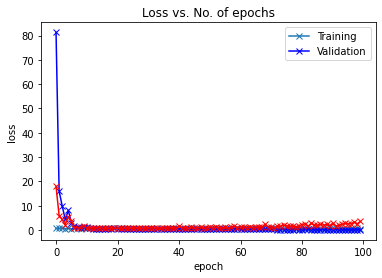

In [44]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [45]:
max([x['val_acc'] for x in history])

0.7162162065505981